In [2]:
using Trixi, OrdinaryDiffEq, Plots

advection_velocity = 1.0
equations = LinearScalarAdvectionEquation1D(advection_velocity)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ LinearScalarAdvectionEquation1D                                                                  │
│ ═══════════════════════════════                                                                  │
│ #variables: ………………………………………………… 1                                                                │
│ │ variable 1: …………………………………………… scalar                                                           │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘

In [3]:
coordinates_min = 0.0 # minimum coordinate
coordinates_max = 2.0 # maximum coordinate

init = 4
N = 2^init
dx = abs(coordinates_max-coordinates_min)/N
mesh = TreeMesh(coordinates_min, coordinates_max,
                initial_refinement_level=init, # number of elements = 2^init
                n_cells_max=30_000)
dt = 0.9*dx
timesteps = 5
tspan = (0.0, timesteps*dt)

surface_flux = flux_lax_friedrichs
dg = DGSEM(polydeg=1)
initial_condition_sine_wave(x, t, equations) = SVector(1.0 + 0.5 * sin(pi * sum(x - equations.advection_velocity * t)))

semi = SemidiscretizationHyperbolic(mesh,equations,initial_condition_sine_wave,dg)
cache = semi.cache


#not needed for trixi
grid = collect(coordinates_min:dx:coordinates_max);
x_values = grid[1:(end-1)].+(dx/2);

LF(u_l,u_r) = 0.5*(u_l+u_r)-dx/(2*dt)*(u_r-u_l)

LF (generic function with 1 method)

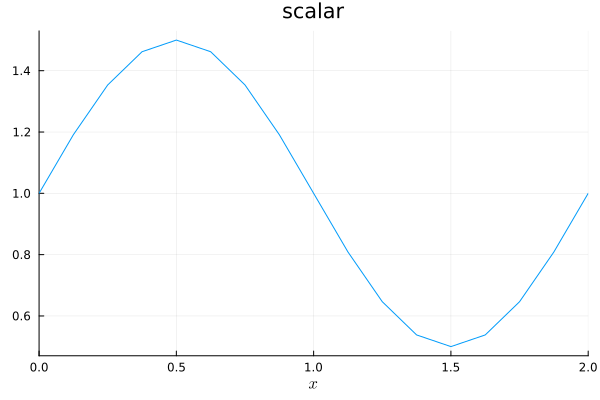

In [97]:
u = compute_coefficients(first(tspan),semi)
pd_0 = PlotData1D(u,semi)
plot(pd_0)

In [96]:
function FV_classic_trixi(u0, surface_flux, equations,dg, cache,dt,dx)
    c = deepcopy(u0)
    copy = Trixi.wrap_array(c,mesh,equations,dg,cache)
    u0_wrap = Trixi.wrap_array(u0,mesh,equations,dg,cache)
    for interface in 2:(Trixi.ninterfaces(dg,cache))
        u_ll, u_rr = Trixi.get_surface_node_vars(copy, equations, dg, interface-1)
        flux1 = surface_flux(u_ll,u_rr,1,equations)
        u_ll_2, u_rr_2 = Trixi.get_surface_node_vars(copy, equations,dg,interface)
        flux2 = surface_flux(u_ll_2,u_rr_2,1,equations)
        Trixi.multiply_add_to_node_vars!(u0_wrap,-dt/dx,flux2-flux1,equations,dg,2,interface-1)
        Trixi.multiply_add_to_node_vars!(u0_wrap,-dt/dx,flux2-flux1,equations,dg,1,interface)
    end
    u_ll, u_rr = Trixi.get_surface_node_vars(copy, equations, dg, Trixi.ninterfaces(dg,cache))
    flux1 = surface_flux(u_ll,u_rr,1,equations)
    u_ll_2, u_rr_2 = Trixi.get_surface_node_vars(copy, equations,dg,1)
    flux2 = surface_flux(u_ll_2,u_rr_2,1,equations)
    Trixi.multiply_add_to_node_vars!(u0_wrap,-dt/dx,flux2-flux1,equations,dg,1,1)
    Trixi.multiply_add_to_node_vars!(u0_wrap,-dt/dx,flux2-flux1,equations,dg,2,Trixi.ninterfaces(dg,cache))
    return
end

FV_classic_trixi (generic function with 1 method)

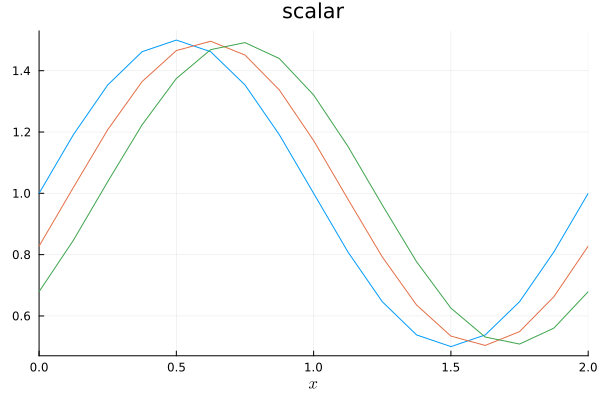

In [99]:
FV_classic_trixi(u,surface_flux,equations,dg,cache,dt,dx)
pd = PlotData1D(u,semi)
plot!(pd)

In [19]:
function flux_test(u0, surface_flux, equations,dg, cache,dt,dx)
    u0_wrap = Trixi.wrap_array(u0,mesh,equations,dg,cache)
    numflux = zeros(Trixi.ninterfaces(dg,cache))
    for interface in 2:(Trixi.ninterfaces(dg,cache))
        u_ll, u_rr = Trixi.get_surface_node_vars(u0_wrap, equations, dg, interface-1)
        #flux1 = surface_flux(u_ll,u_rr,1,equations)
        flux1 = LF(u_ll,u_rr)
        u_ll_2, u_rr_2 = Trixi.get_surface_node_vars(u0_wrap, equations,dg,interface)
        #flux2 = surface_flux(u_ll_2,u_rr_2,1,equations)
        flux2 = LF(u_ll_2,u_rr_2)
        numflux[interface]= (flux2-flux1)[1]
    end
    return numflux
end

flux_test (generic function with 1 method)

In [20]:
fluss = flux_test(u,surface_flux,equations,dg,cache,dt,dx)

16-element Vector{Float64}:
  0.0
  0.19296005183653475
  0.16520196878563742
  0.11229338354670393
  0.042289148604840676
 -0.03415322586002256
 -0.10539608128746081
 -0.1605933387567391
 -0.1913417161825448
 -0.19296005183653464
 -0.16520196878563786
 -0.11229338354670348
 -0.04228914860484084
  0.03415322586002273
  0.10539608128746047
  0.16059333875673887

In [25]:
dt/dx.*fluss

16-element Vector{Float64}:
  0.0
  0.1736640466528813
  0.14868177190707368
  0.10106404519203353
  0.03806023374435661
 -0.030737903274020307
 -0.09485647315871473
 -0.1445340048810652
 -0.17220754456429033
 -0.17366404665288118
 -0.14868177190707407
 -0.10106404519203314
 -0.03806023374435676
  0.030737903274020456
  0.09485647315871443
  0.144534004881065

In [27]:
1.1913417161825448-0.1736640466528813

1.0176776695296634